# CatBoostRegression Year column embedding    
    1. Year column embedding code to preserve time series properties.
    2. stock별 시계열패턴을 모델이 학습할수 있도록 작성된 코드.

In [1]:
import pandas as pd
from catboost import CatBoostRegressor

# CatBoost 다중 타겟: loss_function='MultiRMSE' 사용 (y shape: [n_samples, n_targets])
model = CatBoostRegressor(
    iterations=800,
    max_depth=8,
    learning_rate=0.06,
    loss_function='MultiRMSE',  # 다중 회귀 손실
    eval_metric='MultiRMSE',
    task_type='GPU',   # GPU 사용
    devices='0',
    boosting_type='Plain',
    random_seed=42,
    early_stopping_rounds=80,
    verbose=100
)
model


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/super/anaconda3/envs/dh_catboost/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/super/anaconda3/envs/dh_catboost/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/super/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/super/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
 

AttributeError: _ARRAY_API not found

In [2]:
# Set target_columns
target_columns = ['CETR', 'GETR', 'TSTA', 'TSDA']

In [3]:
# Load CSV file
df = pd.read_csv('data.csv')
df.shape

(12653, 65)

In [4]:
# Set categorical_cols
categorical_cols = ['name', 'stock', 'KOSPI', 'big4', 'LOSS', 'ind']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print(df.dtypes)

name        category
stock       category
year           int64
KOSPI       category
fnd_year       int64
              ...   
A_CETR       float64
A_GETR3      float64
A_CETR3      float64
A_GETR5      float64
A_CETR5      float64
Length: 65, dtype: object


In [5]:
# Time-series aware encoding & global cutoff split (2011~2023 train, 2024 test)
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# ---- CONFIG ----
STRICT_LAG = True  # True: 이전 해(year-1)가 있는 행(연속 연도)만 학습/평가 사용

# 1. Year 기반 전역/종목별 트렌드 & 주기 인코딩
year_min = df['year'].min()
year_max = df['year'].max()

# 전역 정규화 (0~1)
df['year_norm_global'] = (df['year'] - year_min) / (year_max - year_min)

# 종목별 시작 index (0부터), 상대적 진행도
df['year_index_stock'] = df.groupby('stock', observed=True)['year'].rank(method='dense').astype(int) - 1
# 종목별 상대적 진행도 (0~1)
df['year_norm_stock'] = df['year_index_stock'] / df.groupby('stock', observed=True)['year_index_stock'].transform('max')

# 주기성 (사이클) 표현: 한 전체 구간(2011~2024)을 하나의 2π 주기로 가정
angle = 2 * np.pi * df['year_norm_global']
df['year_sin'] = np.sin(angle)
df['year_cos'] = np.cos(angle)

# 2. Lag 특징 (1-step) 생성: 전체 df 기준(필터 이전) -> 제거된 연도의 값이 다음 해 lag로 사용 (Option A)
exclude_for_lag = set(['name', 'stock', 'year'] + target_columns)
num_cols_for_lag = [c for c in df.columns if c not in exclude_for_lag and df[c].dtype.kind in ['i','u','f']]
for col in num_cols_for_lag:
    df[f'{col}_lag1'] = df.groupby('stock', observed=True)[col].shift(1)

# 2-1. 실제 연속 연도 여부 계산 (gap 정보)
df['year_gap'] = df.groupby('stock', observed=True)['year'].diff()
df['has_prev_year'] = df['year_gap'].eq(1)

# 3. 전역 컷오프 기반 연도 분리 (Train: <=2023, Test: 2024)
CUTOFF_TEST_YEAR = 2024
train_mask_full = df['year'] < CUTOFF_TEST_YEAR
full_test_mask = df['year'] == CUTOFF_TEST_YEAR

train_df = df[train_mask_full].copy()
test_df = df[full_test_mask].copy()

# 4. 2024 테스트셋: 과거(2011~2023) 기록이 있는 종목만 사용 (seen stocks)
seen_stocks = set(train_df['stock'].unique())
seen_test_df = test_df[test_df['stock'].isin(seen_stocks)].copy()

# 4-1. STRICT_LAG 적용: 직전 연도가 실제로 존재(연속)하는 행만 유지
if STRICT_LAG:
    before_train_rows = len(train_df)
    before_test_rows = len(seen_test_df)
    train_df = train_df[train_df['has_prev_year']].copy()
    seen_test_df = seen_test_df[seen_test_df['has_prev_year']].copy()
    removed_train = before_train_rows - len(train_df)
    removed_test = before_test_rows - len(seen_test_df)
else:
    removed_train = 0
    removed_test = 0

# 5. Feature / Target 분리
feature_drop = ['name', 'stock'] + target_columns
X_train = train_df.drop(columns=feature_drop)
X_test_seen = seen_test_df.drop(columns=feature_drop)
y_train = train_df[target_columns]
y_test_seen = seen_test_df[target_columns]

# 6. Lag 결측 처리 (STRICT_LAG이므로 주로 첫 해 제거되어 NaN 적음)
lag_cols = [c for c in X_train.columns if c.endswith('_lag1')]
if lag_cols:
    # 남아있는 NaN (혹시라도) 채우기
    lag_medians = X_train[lag_cols].median()
    X_train[lag_cols] = X_train[lag_cols].fillna(lag_medians)
    X_test_seen[lag_cols] = X_test_seen[lag_cols].fillna(lag_medians)


In [6]:
from catboost import Pool

# 7. CatBoost Pool 생성 (category dtype 유지된 컬럼 식별)
cat_feature_names = [c for c in X_train.columns if str(train_df[c].dtype) == 'category']
cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_feature_names]

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_feature_indices)
valid_pool = Pool(data=X_test_seen, label=y_test_seen, cat_features=cat_feature_indices)

print(f"Train years: {int(train_df['year'].min())}-{int(train_df['year'].max())} | Test year: {CUTOFF_TEST_YEAR}")
print(f"Cutoff and Seen stocks count in train_df: {len(seen_stocks)}")
print("STRICT_LAG:", STRICT_LAG, f"| Removed train rows: {removed_train} | Removed test rows: {removed_test}")
print("Shapes -> Train:", X_train.shape, "SeenTest:", X_test_seen.shape)
print("Lag feature count:", len(lag_cols))
print("Sample feature cols:", X_train.columns[:12].tolist())

Train years: 2012-2023 | Test year: 2024
Cutoff and Seen stocks count in train_df: 1693
STRICT_LAG: True | Removed train rows: 2472 | Removed test rows: 96
Shapes -> Train: (9095, 125) SeenTest: (929, 125)
Lag feature count: 59
Sample feature cols: ['year', 'KOSPI', 'fnd_year', 'fiscal', 'ind', 'big4', 'forn', 'own', 'c_asset', 'inv', 'asset', 'sales']


In [ ]:
# 7. 모델 학습 & 평가 (CatBoost Pool 사용)
model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

pred_seen = model.predict(valid_pool)  # shape: (n_samples, n_targets)
print('[Seen Stocks 2024] R2:', r2_score(y_test_seen, pred_seen),
      'MAE:', mean_absolute_error(y_test_seen, pred_seen),
      'RMSE:', root_mean_squared_error(y_test_seen, pred_seen))

In [ ]:

# 타겟별 상세
print('\nPer-target metrics:')
for i, col in enumerate(target_columns):
    r2_i = r2_score(y_test_seen[col], pred_seen[:, i])
    mae_i = mean_absolute_error(y_test_seen[col], pred_seen[:, i])
    rmse_i = root_mean_squared_error(y_test_seen[col], pred_seen[:, i])
    print(f"  {col}: R2={r2_i:.4f} MAE={mae_i:.4f} RMSE={rmse_i:.4f}")

# importance
fi = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('\nTop 25 Feature Importances:')
print(fi.head(25))

            R2       MAE      RMSE
CETR  0.989932  0.015695  0.022208
GETR  0.971945  0.015323  0.022303
TSTA  0.922010  0.037651  0.076234
TSDA  0.918525  0.039739  0.079252


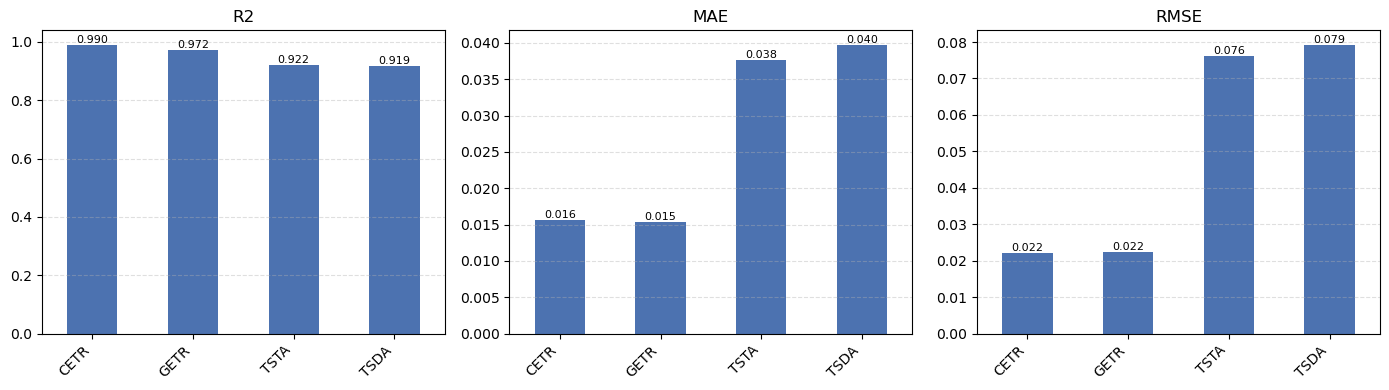

In [8]:
import matplotlib.pyplot as plt

# 타겟별 성능지표 계산
metrics = {'R2': [], 'MAE': [], 'RMSE': []}
for i, col in enumerate(target_columns):
    y_true = y_test_seen[col]
    y_pred = pred_seen[:, i]
    metrics['R2'].append(r2_score(y_true, y_pred))
    metrics['MAE'].append(mean_absolute_error(y_true, y_pred))
    metrics['RMSE'].append(root_mean_squared_error(y_true, y_pred))

metrics_df = pd.DataFrame(metrics, index=target_columns)
print(metrics_df)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, metric in zip(axes, metrics_df.columns):
    axes_idx = metrics_df[metric].plot(kind='bar', ax=ax, color='#4C72B0')
    ax.set_title(metric)
    ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(f'{val:.3f}', (p.get_x() + p.get_width()/2, val),
                    ha='center', va='bottom', fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

In [9]:
# 8. 결과 저장 (Seen test)
import numpy as np
results_df = pd.DataFrame(
    data = np.hstack([y_test_seen.values, pred_seen]),
    columns = [f'actual_{col}' for col in y_test_seen.columns] + [f'pred_{col}' for col in y_test_seen.columns],
    index = y_test_seen.index,
)
results_df.to_csv('actual_vs_predicted_seen_2024_catboost.csv', index=True)
print('Saved: actual_vs_predicted_seen_2024_catboost.csv')

# Per-target metrics 저장
metric_rows = []
for i, col in enumerate(target_columns):
    metric_rows.append({
        'target': col,
        'R2': r2_score(y_test_seen[col], pred_seen[:, i]),
        'MAE': mean_absolute_error(y_test_seen[col], pred_seen[:, i]),
        'RMSE': root_mean_squared_error(y_test_seen[col], pred_seen[:, i])
    })
metrics_df = pd.DataFrame(metric_rows)
metrics_df.to_csv('CatBoost_metrics_seen_2024.csv', index=False)
print('Saved: CatBoost_metrics_seen_2024.csv')

Saved: actual_vs_predicted_seen_2024_catboost.csv
Saved: CatBoost_metrics_seen_2024.csv


## Reference site
    지표 및 점수
    https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation
    https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

    [Training_Parameters] 
    1. https://catboost.ai/docs/en/references/training-parameters/
    2. https://catboost.ai/docs/en/concepts/loss-functions-multiregression
    3. https://catboost.ai/docs/en/concepts/python-reference_catboostregressor